# Modelling Concerns About Personal Information with Structural Equation Modelling


## 1) Data Operations

I first start with loading necessary packages and declaring required magic commands for this analysis.

In [118]:
import pandas as pd
from plotnine import *
import matplotlib.pyplot as plt
import semopy as sm
import warnings
import dowhy
import pygraphviz
from statsmodels.formula.api import ols
from IPython.display import Image, display
#inline plotting for matplotlib in jupyter
%matplotlib inline

#to reload easily
%reload_ext autoreload
%autoreload 2

# I like ggplot style
plt.style.use('ggplot')

# I want the warning to be supressed
warnings.filterwarnings('ignore')

What I am doing below is defining the theoretical scope of this analysis.

The "column_names" list is containing the names of the variables that I am going to use in this analysis. In the next chunk of code, I will be inserting this column into stata reader to make it return only these variables.

This is not an obligation. Especially for doing purely exploratory work, keeping the whole data surely is more beneficial. However, this is not the case here. I want specific set of variables to be read for two reasons. First, I have a theory in mind, and I have no intention to furher explore. Second, the designers of the survey made really terrible choice of variable naming. These are just some random numbers and letters. One can easily make mistakes working with them.

In [65]:
# Column names that I want to keep
column_names = (["Q999","Q91_w7","Q92_w4","Q94_w4",
                 "Q93_w4","Q97_w4", "Q201A_w7","Q201B_w7",
                 "Q201C_w7","Q201D_w7","Q201E_w7","Q60A_w4","Q60B_w4",
                 "Q60C_w4","Q60D_w4","Q60E_w4","Q60F_w4","Q60G_w4",
                 "Q71A_w4","Q71B_w4","Q71C_w4","Q71D_w4","Q72A_w4",
                 "Q72B_w4","Q72C_w4","Q72D_w4","Q73A_w4","Q73B_w4",
                 "Q73C_w4","Q73D_w4","Q74A_w4","Q74B_w4","Q74C_w4",
                 "Q74D_w4","Q75A_w4","Q75B_w4","Q75C_w4","Q75D_w4"])


I am using pandas' stata reader from pandas library. The important point when working with .dta files is you have both numeric versions and labelled versions of the data. In the labelled version one can see questions that are asked in the survey as well as the answers in human language. Whereas the numeric version only contains the numerical representation of the survey. So, in order to understand what we are working with, we have to read both versions of the data. The iterator argument in the reader function allows us to achieve this.

Also, as I mentioned, I passed the column_names here into the function to make stata reader only read the columns in the file that are matching the list.

In [66]:
# Calling the stata reader object
reader = (pd.read_stata(
    'df2.dta',
    columns=column_names,
    iterator=True)
    )

In [67]:
# Reading the labels of the rows
value_labels = reader.value_labels()

In [68]:
# Reading the column labels.
variable_labels = reader.variable_labels()

Below I am calling stata reader's read method with convert categoricals argument as False. This makes stata reader skip the labels and only return the numeric version of the data.

In [69]:
# save the datafame
df = reader.read(convert_categoricals=False)

So, below is a random sample of 5 rows from our dataset. As it stands, it's almost impossible to make sense of it. But with the help of value labels and variable labels we can make sense of it without referring to the questionnaire (the pdf that added to this repo) back and forth.

In [70]:
df.sample(5)

,Q999,Q91_w7,Q92_w4,Q94_w4,Q93_w4,Q97_w4,Q201A_w7,Q201B_w7,Q201C_w7,Q201D_w7,...,Q73C_w4,Q73D_w4,Q74A_w4,Q74B_w4,Q74C_w4,Q74D_w4,Q75A_w4,Q75B_w4,Q75C_w4,Q75D_w4
4147,1.0,NaN,27.0,1.0,3.0,5.0,NaN,NaN,NaN,NaN,...,4.0,5.0,3.0,6.0,5.0,5.0,7.0,3.0,1.0,1.0
2646,1.0,NaN,29.0,1.0,1.0,4.0,NaN,NaN,NaN,NaN,...,7.0,7.0,6.0,6.0,7.0,7.0,6.0,6.0,7.0,7.0
10162,4.0,NaN,28.0,3.0,36.0,5.0,NaN,NaN,NaN,NaN,...,4.0,5.0,6.0,5.0,2.0,3.0,2.0,1.0,6.0,5.0
4475,2.0,NaN,31.0,4.0,20.0,5.0,NaN,NaN,NaN,NaN,...,2.0,4.0,6.0,6.0,2.0,2.0,3.0,2.0,5.0,5.0
89,1.0,1.0,72.0,5.0,4.0,5.0,7.0,7.0,7.0,7.0,...,1.0,1.0,7.0,7.0,1.0,1.0,4.0,2.0,6.0,6.0


In [71]:
# showing the definitions of first three questions
list(variable_labels.items())[:3]

[('za_nr', 'ZA Study Number'),
 ('version', 'GESIS Archive Version'),
 ('doi', 'Digital Object Identifier')]

In [72]:
# showing the value labels of first 3 questions
list(value_labels.items())[:3]

[('noyes', {0: ' No', 1: 'Yes'}),
 ('countryX',
  {0: ' Netherlands',
   1: 'Denmark',
   2: 'Germany',
   3: 'Hungary',
   4: 'Spain',
   6: 'Czech Republic',
   7: 'France',
   8: 'Greece',
   9: 'Poland',
   10: 'Sweden'}),
 ('OCCUPATION',
  {1: 'Legislator, Senior Official, or Manager',
   2: 'Professional (engineer, doctor, teacher, clergy, etc.)',
   3: 'Technician or Associate Professional (inspector, finance dealer, etc.)',
   4: 'Clerk (secretary, cashier, etc.)',
   5: 'Service or sales worker (cook, travel guide, shop salesperson, etc.)',
   6: 'Agricultural or fishery worker (vegetable grower, livestock producer, etc.)',
   7: 'Craft or trades worker (carpenter, painter, jewelry worker, butcher, etc.)',
   8: 'Plant/machine operator or assembler (equipment assembler, sewing-machine operato',
   9: 'Elementary worker (street food vendor, shoe cleaner, etc.)',
   10: 'Armed forces (government military)'})]

These two will help us to understand what we are working with.

The first challenge arises here. For some reason variable_labels and value_labels are returning the whole dataset rather than the list of columns that I declared. I want the variable labels of the columns that I declared, not all variables. This is either caused by me using the method in a wrong way, or it's designed this way. Most probably there's a solution in the docs or somewhere in stackoverflow, but here I take it as a good coding challenge.

So in order to get that, I will use a lambda function that goes through variable labels dictionary and preserve elements only when the key is matching my column_names list.

In [73]:
# Function to preserve the elements that are matching
dict_filter = lambda var, names: dict([ (element,var[element]) for element in var if element in names ])

# Apply the filter to our dataset
labels = dict_filter(variable_labels, column_names)

Above code achieved what I aimed for. As I feel more comfortable with dataframes rather than dictionaries, I would like to make a neat data frame of variable names and questions that they are referring to. For that one, I loop over the dictionary items and construct a dataframe.

In [74]:
variable = []
question = []
for key, value in labels.items():
    variable.append(key)
    question.append(value)

# Convert the dictionary to pandas dataframe
map_df = pd.DataFrame({"variable":variable, "question":question})

In [75]:
# Result
map_df

,variable,question
0,Q91_w7,Q91: Gender
1,Q201A_w7,Q201a: Privacy concern (I am concerned that my...
2,Q201B_w7,Q201b: Privacy concern (When I visit websites ...
3,Q201C_w7,Q201c: Privacy concern (I am afraid that my pe...
4,Q201D_w7,Q201d: Privacy concern (I am concerned that my...
5,Q201E_w7,Q201e: Privacy concern (I am concerned that my...
6,Q92_w4,Q92: Age
7,Q93_w4,Q93: region
8,Q94_w4,Q94: Urbanization
9,Q71A_w4,Q71a IPIP Have a vivid imagination


After creating this reference data frame, now I would like to get rid of uninformative variable names by replacing them with the ones that are more easily recognisable. I constructed the dictionary below for this purpose.

The variable naming that I chose is actually rooted in the theory behind the survey design. If you check the questions above, you might realize that some set of questions are actually really close to each other in terms of what they intended to measure. This is a latent variable construct. For instance, the questions that I renamed with "open_" prefix are specially designed to measure the opennes of respondents personality. Similarly "agrb_" prefix refers to set of questions intended to measure the respondents agreeableness. Those latent constructs together form the Big-Five personality traits taxonomy. The researchers who created the questionnaire did this on purpose. They are measuring the big-5.

Similar latent construct story holds true for "pi_ prefix". With that set of questions, the concerns about personal information (privacy concerns) are measured.

The questions measuring trust in political institutions can also be grouped together under one latent variable or they can be treated independently. This is a design choice. In this analysis I choose to group them under a latent variable for two reasons. First, from the theoretical perspective, I don't want to make distinct hypotheses about each different institution. I am interested in trust in political institutions altogether. Second, even if the one chooses to model the trust for each institutions separately in a regression model, this can cause multicollinearity because most of the time they yield correlated results conditional on your target variable.

In [76]:
column_map = ({"Q999": "country", "Q91_w7": "gender",
               "Q92_w4": "age", "Q94_w4":"urbanization",  "Q93_w4": "region",
               "Q97_w4": "income", "Q201A_w7": "pi_misuse",
               "Q201B_w7": "pi_track", "Q201C_w7": "pi_safety", "Q201D_w7": "pi_share",
               "Q201E_w7": "pi_stranger", "Q60A_w4": "trst_prl", "Q60B_w4": "trst_pol",
               "Q60C_w4": "trst_prt", "Q60D_w4": "trst_leg", "Q60E_w4": "trst_plc",
               "Q60F_w4": "trst_gov", "Q60G_w4": "trst_eu", "Q71A_w4": "open_a",
               "Q71B_w4": "open_b", "Q71C_w4": "open_c", "Q71D_w4": "open_d",
               "Q72A_w4": "cons_a", "Q72B_w4": "cons_b", "Q72C_w4": "cons_c",
               "Q72D_w4": "cons_d", "Q73A_w4": "extr_a", "Q73B_w4": "extr_b",
               "Q73C_w4": "extr_c", "Q73D_w4": "extr_d", "Q74A_w4": "agrb_a",
               "Q74B_w4": "agrb_b", "Q74C_w4": "agrb_c", "Q74D_w4": "agrb_d",
               "Q75A_w4": "neur_a", "Q75B_w4": "neur_b", "Q75C_w4": "neur_c",
               "Q75D_w4": "neur_d"})

In [77]:
df.rename(columns=column_map, inplace=True)

Great, now everything suits my liking.  Now we can explore what stories we have within.

In [78]:
df.sample(5)

,country,gender,age,urbanization,region,income,pi_misuse,pi_track,pi_safety,pi_share,...,extr_c,extr_d,agrb_a,agrb_b,agrb_c,agrb_d,neur_a,neur_b,neur_c,neur_d
7038,3.0,NaN,20.0,3.0,23.0,2.0,NaN,NaN,NaN,NaN,...,3.0,3.0,5.0,5.0,3.0,3.0,3.0,3.0,5.0,5.0
3036,1.0,NaN,60.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,...,7.0,7.0,4.0,7.0,4.0,4.0,4.0,4.0,4.0,4.0
7803,3.0,NaN,52.0,4.0,24.0,5.0,NaN,NaN,NaN,NaN,...,7.0,5.0,7.0,6.0,3.0,3.0,5.0,1.0,5.0,4.0
3513,1.0,NaN,33.0,5.0,4.0,5.0,NaN,NaN,NaN,NaN,...,2.0,2.0,5.0,5.0,4.0,4.0,3.0,4.0,4.0,5.0
7827,3.0,NaN,51.0,1.0,25.0,6.0,NaN,NaN,NaN,NaN,...,1.0,4.0,7.0,7.0,1.0,1.0,1.0,1.0,4.0,7.0


The first thing I would do is to check the shape of the data frame. We are talking about 11k observations with 38 variables. But I can see lots of NaNs in the dataframe. In the following lines I would like to make a report of missing values in order to decide my strategy to tackle it.

In [79]:
df.shape

Below is the set of variables that are containing missing values. Remaining 31 variables are not containing any missing values. But the vital question is what is the amount of missing values? Just to check that I will first acquire percentage of valid values in all columns. The count() method counts the valid observations in the dataframe and len() returns the number of total observations regardless of their status. By dividing valid ones to the total length, I acquire the percentage of valid observations.

In [80]:
# list the column names that contain missing vals
list(df.columns[df.isnull().mean() != 0])

['gender',
 'region',
 'pi_misuse',
 'pi_track',
 'pi_safety',
 'pi_share',
 'pi_stranger']

In [81]:
# Percentage of valid observations for all variables
report_observations = pd.DataFrame(df.count() / len(df),columns=["percentage"]).\
    reset_index().\
    rename(columns={"index":"variable"})

In [82]:
# Percentage of valid observations within the subset of columns that contain missing values
report_missing = report_observations[report_observations.percentage < 1]

In [83]:
report_missing

,variable,percentage
1,gender,0.198373
4,region,0.981316
6,pi_misuse,0.198373
7,pi_track,0.198373
8,pi_safety,0.198373
9,pi_share,0.198373
10,pi_stranger,0.198373


Well, as concerns about personal information is my latent target variable in this analysis, it saddens me to see huge chunk of missing values are actually on those items that are measuring this latent variable. Let's make a sad visualisation of structure of missing values in this dataset.

<BarContainer object of 7 artists>

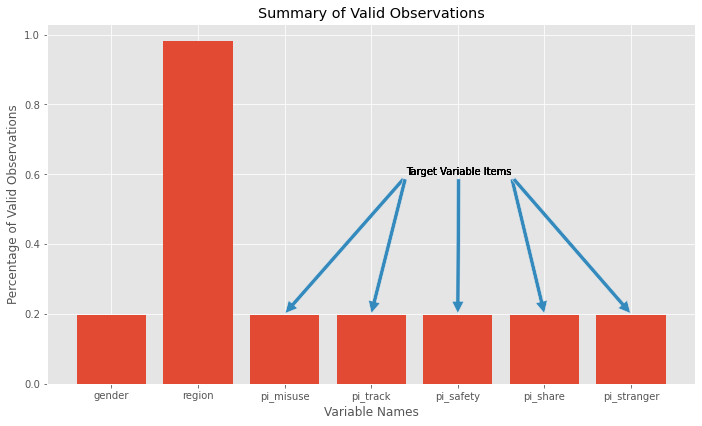

In [84]:
fig_1 = plt.figure(figsize=(9,5))
axes_1 = fig_1.add_axes([0,0,1, 1])
axes_1.set_title("Summary of Valid Observations")
axes_1.set_xlabel("Variable Names")
axes_1.set_ylabel("Percentage of Valid Observations")
for i in range(2,7):
    axes_1.annotate("Target Variable Items", xy=(i,0.2), xytext=(3.4,0.6,),
                    arrowprops =dict( shrink=0.005))
axes_1.bar(report_missing["variable"], report_missing["percentage"])

Since the items measuring concerns about personal information has the most missing values, that makes not much sense to consider other missing data strategies than dropping the all cases. The reason is, let's say, even if I use missing data imputation methods on other variables, the target variable would be still containing missing values. That brings me no additional benefit.

In [85]:
df.dropna(subset=['pi_misuse', 'pi_track', 'pi_safety', 'pi_share', 'pi_stranger',], how="any", inplace=True)

In [86]:
df.shape

In [87]:
df.columns

Index(['country', 'gender', 'age', 'urbanization', 'region', 'income',
       'pi_misuse', 'pi_track', 'pi_safety', 'pi_share', 'pi_stranger',
       'trst_prl', 'trst_pol', 'trst_prt', 'trst_leg', 'trst_plc', 'trst_gov',
       'trst_eu', 'open_a', 'open_b', 'open_c', 'open_d', 'cons_a', 'cons_b',
       'cons_c', 'cons_d', 'extr_a', 'extr_b', 'extr_c', 'extr_d', 'agrb_a',
       'agrb_b', 'agrb_c', 'agrb_d', 'neur_a', 'neur_b', 'neur_c', 'neur_d'],
      dtype='object')

Even though the structural equation modelling package, semopy, will let me define the latent constructs, I still create additive indices for each latent construct. The first reason for doing so is that it makes the exploration via visualisation much easier. However, the more important reason is, I will not only use semopy for modelling. Besides SEM, I will make a classical multivariate regression model as well as using causal modelling via DoWhy. These two can't deal with latent variables.

From the visualisation perspective, considering the fact that tha latent variables are measured by sub-items this creates a problem of dimensions. In order to reduce the number of plots that I have to make, I will lower down the number of dimensions that I work with by the help of those indeces.

An additive index is just adding the sub-dimension and averaging. Not something super fancy but literature is full of them :)

In [88]:
df["openness"] = (df["open_a"] + df["open_b"] + df["open_c"]+ df["open_d"]) / 4
df["conscientiousness"] = (df["cons_a"] + df["cons_b"] + df["cons_c"]+ df["cons_d"]) / 4
df["agreeableness"] = (df["agrb_a"] + df["agrb_b"] + df["agrb_c"]+ df["agrb_d"]) / 4
df["extraversion"] = (df["extr_a"] + df["extr_b"] + df["extr_c"]+ df["extr_d"]) / 4
df["neuroticism"] = (df["neur_a"] + df["neur_b"] + df["neur_c"]+ df["neur_d"]) / 4
df["pi_concerns"] = (df["pi_misuse"] + df["pi_track"] + df["pi_share"]+ df["pi_safety"] + df["pi_stranger"])  / 5
df["trust_in_inst"] = (df["trst_leg"] + df["trst_eu"] + df["trst_gov"]+ df["trst_plc"] + df["trst_pol"]+ df["trst_prl"] + df["trst_prl"]) / 7

In [89]:
df.head()

,country,gender,age,urbanization,region,income,pi_misuse,pi_track,pi_safety,pi_share,...,neur_b,neur_c,neur_d,openness,conscientiousness,agreeableness,extraversion,neuroticism,pi_concerns,trust_in_inst
0,1.0,2.0,34.0,1.0,5.0,2.0,5.0,5.0,5.0,5.0,...,4.0,4.0,2.0,3.25,4.25,3.75,3.25,3.25,5.0,2.428571
1,1.0,1.0,34.0,3.0,4.0,2.0,1.0,7.0,1.0,1.0,...,1.0,7.0,4.0,5.50,4.00,4.75,4.00,4.75,2.2,7.000000
2,1.0,1.0,65.0,3.0,5.0,3.0,4.0,5.0,4.0,4.0,...,5.0,6.0,4.0,3.00,4.50,4.00,4.00,4.75,4.2,4.285714
3,1.0,1.0,32.0,3.0,4.0,4.0,6.0,7.0,5.0,5.0,...,3.0,6.0,3.0,2.75,5.00,4.25,3.50,3.75,5.6,3.285714
4,1.0,1.0,55.0,3.0,4.0,4.0,5.0,5.0,5.0,5.0,...,2.0,6.0,5.0,2.75,5.00,3.25,3.75,4.00,5.0,3.285714


In this analysis I will not use categorical variables as my predictors in the modelling section. However, I still want to convert these two categorical variables into their proper types. I keep them ready, in case I want to explore further research avenues by involving these two into my models.

In [90]:
df.country.replace({1: "Denmark",
                    2: "Germany",
                    3:"Hungary",
                    4:"Spain"},
                   inplace=True)

In [91]:
df.urbanization.replace({1: 'Big City',
                         2: 'Outer Big City',
                         3: 'Town/Small City',
                         4: 'Village',
                         5: 'Farm'},
                        inplace=True)

In [92]:
df.urbanization = df.urbanization.astype("category")
df.country = df.country.astype("category")


In [93]:
df.urbanization.dtype

CategoricalDtype(categories=['Big City', 'Farm', 'Outer Big City', 'Town/Small City',
                  'Village'],
, ordered=False)

## 2) Exploration
In this section I would like to explore the isolated relationships between certain variables.

First thing that we have to keep in mind is that the most of the variables are discrete variables. This makes plotting and exploration phase little bit tricky. If you make a plot of discrete variable against another discrete variable, then what you'll end up with will not be informative plot. Let me quickly demonstrate the problem


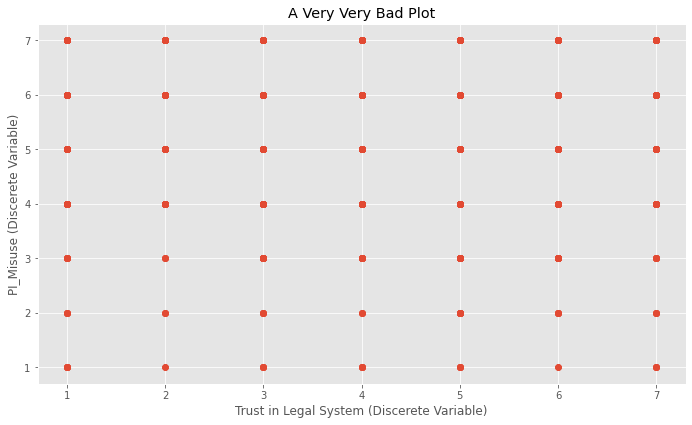

In [94]:
fig = plt.figure(figsize=(9,5))
axes = fig.add_axes([0,0,1, 1])
axes.set_title("A Very Very Bad Plot")
axes.set_ylabel("PI_Misuse (Discerete Variable)")
axes.set_xlabel("Trust in Legal System (Discerete Variable)")
plt.scatter(df["trst_leg"], df["pi_misuse"])

For this reason, when working with discrete variables, directly plotting variables against each other is not a smart idea (with scatters, lines etc). We need some transformation on the variables or should go for another plotting technique. What I am going to do during the exploration phase is, I just simply keep my X variable as is, while replacing Y with the mean of the Y for each level in X. Following the example above, for each level in "trst_leg", I will calculate the mean of "pi_misuse" and plot them. Below plot is how it looks in action

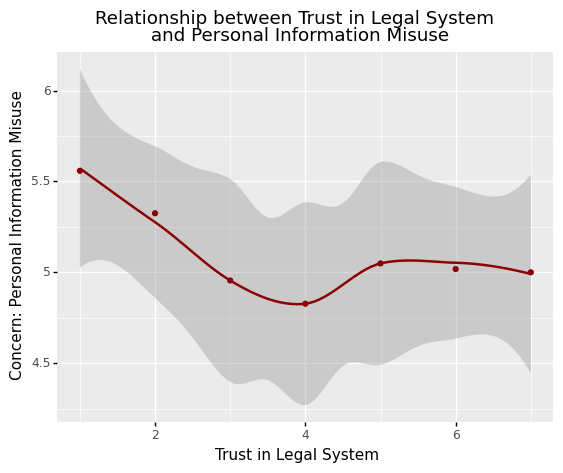

<ggplot: (8781909336336)>

In [95]:
#Grouping by trst leg values and replacing pi_misuse with the mean of it
mask = df.groupby("trst_leg")["pi_misuse"].mean().reset_index().copy()
# create the plot
example_plot = (
        ggplot(mask,
               aes(x="trst_leg", y="pi_misuse")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color= "darkred") +
        xlab("Trust in Legal System") +
        ylab("Concern: Personal Information Misuse") +
        ggtitle("Relationship between Trust in Legal System \n and Personal Information Misuse")
                )
# save the plot
ggplot.save(self= example_plot,
            filename="example_plot.png",
            path="plots/")
# display the plot
example_plot

However, it is important to notice that when we are applying this transformation we are basically getting rid of some regional variation in the data by reducing the whole distribution of Y on any single point of X into a single statistic. This transformation can help us get an idea about direction of the relationship between two discrete variables. It shouldn't be used for jumping on over confident conclusions about the functional form of the relationship.

I use plotnine package as it allows us to use almost all capabilities of R's legendary Ggplot package. The most beneficial part of this library is that it has super easy curve fitting function. As far as I am aware, seaborn also has some curve fitting functionality however plotnine's layered grammar of graphics is much easy to customise.

A note for udacity reviewer: I know it looks like I am trying to cheat by using a package that relies on R's grammar. But this is still a python package. It doesn't use rpy2 or any sort of R to Python converter. Everything in this package is pure python. To a degree, by using this package I am not leaving my comfort zone however plotnine is more capable than seaborn or plotly. Plus, it is hell of a lot quicker to create visualisations than matplotlib.

### 2.1) Demographic Variables on Digital Privacy Concerns

I will plot the demographics here. Demographics are not part of my core three research questions but they are almost always included in any analysis as control variables.

#### 2.1.A) Age on Digital Privacy Concerns

The first demographic variable is Age. Seems like age is "associated" with increase in Digital Privacy Concerns up until around 70 years. Then the slope turns negative. However, it's important that we shouldn't make any causal conclusions here. It might be cohort or generation effects. Currently I am 30 years old and this plot is not saying that when I get to 70 my concerns about personal information is expected to increase.

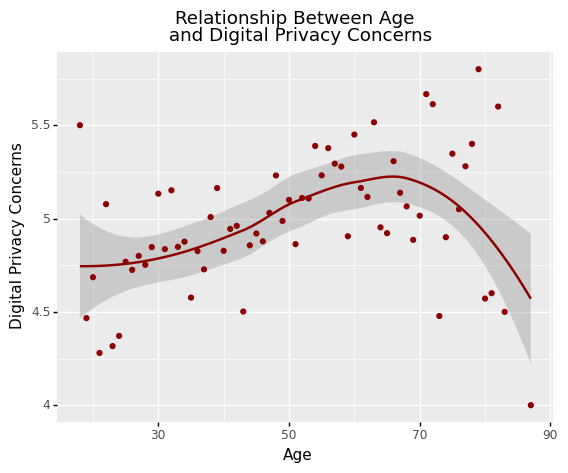

<ggplot: (8781894083862)>

In [96]:
mask = df.groupby("age")["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
age_vs_pi = (
        ggplot(mask,
               aes(x="age", y="pi_concerns")) +
        geom_smooth(method="loess",
                    se=True,
                    color="darkred") +
        geom_point(color="darkred") +
        xlab("Age") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Age \n and Digital Privacy Concerns")
            )
# save the plot
ggplot.save(self=age_vs_pi,
            filename="age_vs_pi.png",
            path="plots/")
# display the plot
age_vs_pi

#### 2.1.B) Gender on Digital Privacy Concerns
Average personal information concerns looks very similar in each country. Spain and Germany scoring higher.

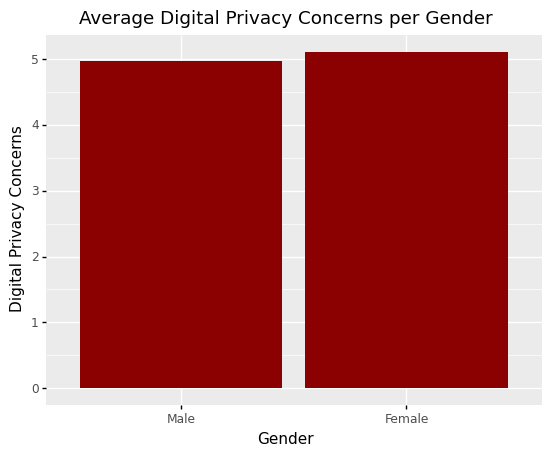

<ggplot: (8781893699563)>

In [97]:
mask = df.groupby("gender")["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# Create the plot
gender_vs_pi = (
        ggplot(mask,
               aes(x="factor(gender)", y="pi_concerns")) +
        geom_col(stat="identity", fill="darkred") +
        xlab("Gender") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Average Digital Privacy Concerns per Gender") +
        scale_x_discrete(name = "Gender",
                         breaks=[1,2],
                         labels=["Male", "Female"])
                )
# save plot
ggplot.save(self=gender_vs_pi,
            filename="gender_vs_pi.png",
            path="plots/")

# display the plot
gender_vs_pi

#### 2.1.C) Income on Digital Privacy Concerns


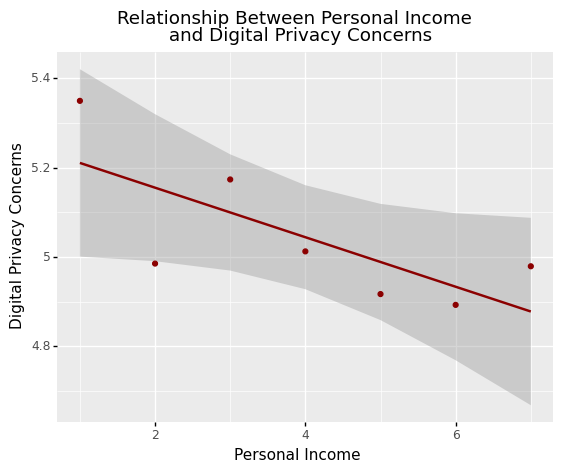

<ggplot: (8781891889312)>

In [98]:
mask = df.groupby("income")["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)
# changing dtype to int is necessary for this plot
mask.income = mask.income.astype("int")

# create the plot
income_vs_pi = (
        ggplot(mask,
               aes(x="income", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Personal Income") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Personal Income \n and Digital Privacy Concerns")
                )
ggplot.save(self=income_vs_pi,
            filename="income_vs_pi.png",
            path="plots/")

# display the plot
income_vs_pi


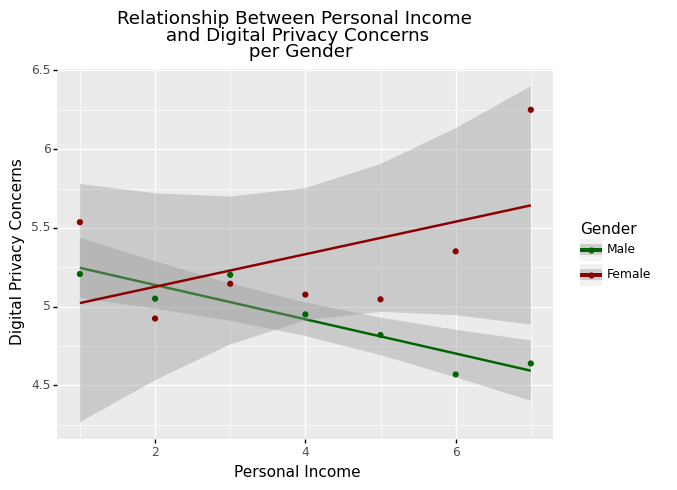

<ggplot: (8781889557438)>

In [99]:
mask = df.groupby(["income", "gender"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)
mask.income = mask.income.astype("int")

# create the plot
income_vs_pi_gendered = (
    ggplot(mask,
           aes(x="income", y="pi_concerns", color="factor(gender)")) +
    geom_smooth(method="lm", se=True) +
    geom_point() +
    xlab("Personal Income") +
    ylab("Digital Privacy Concerns") +
    scale_color_manual(name = "Gender",
                       values=["darkgreen", "darkred"],
                       labels=["Male", "Female"]) +
    ggtitle("Relationship Between Personal Income \n and Digital Privacy Concerns \n per Gender")
                        )
# save the plot
ggplot.save(self=income_vs_pi_gendered,
            filename="income_vs_pi_gendered.png",
            path="plots/")

# display the plot
income_vs_pi_gendered




#### 2.1.D) Urbanization on Digital Privacy Concerns


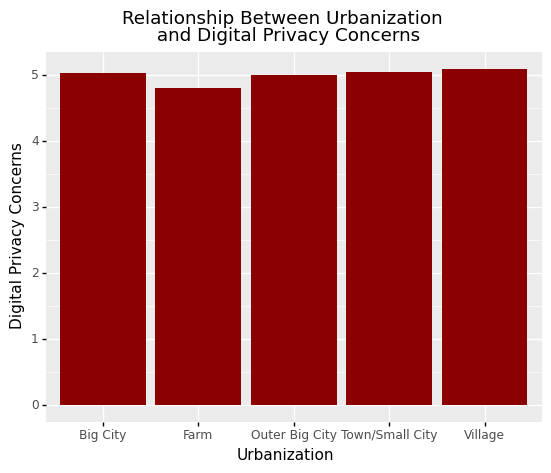

<ggplot: (8781888694791)>

In [100]:
mask = df.groupby(["urbanization"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
urbanization_vs_pi = (
        ggplot(mask,
               aes(x="urbanization", y="pi_concerns")) +
        geom_col(stat="identity", fill="darkred") +
        xlab("Urbanization") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Urbanization \n and Digital Privacy Concerns")
                     )
# save the plot
ggplot.save(self=urbanization_vs_pi,
            filename="urbanization_vs_pi.png",
            path="plots/")

# display the plot
urbanization_vs_pi


### 2.2) Trust In Institutions on Digital Privacy Concerns

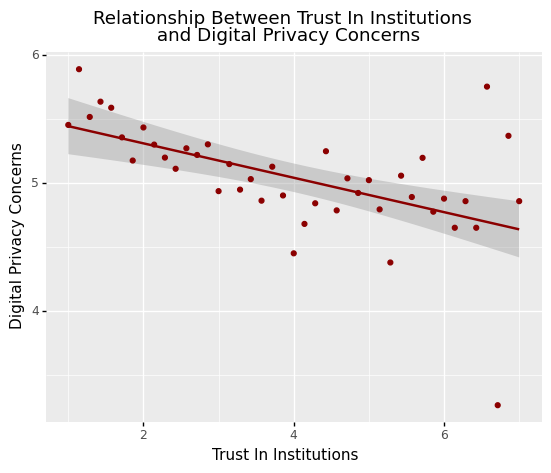

<ggplot: (8781893038008)>

In [101]:
mask = df.groupby(["trust_in_inst"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
trst_inst_vs_pi = (
        ggplot(mask,
               aes(x="trust_in_inst", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Trust In Institutions") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Trust In Institutions \n and Digital Privacy Concerns")
                  )
# save the plot
ggplot.save(self=trst_inst_vs_pi,
            filename="trst_inst_vs_pi.png",
            path="plots/")

# display the plot
trst_inst_vs_pi


### 2.3) Personality Traits on Digital Privacy Concerns
#### 2.3.A) Openness on Digital Privacy Concerns

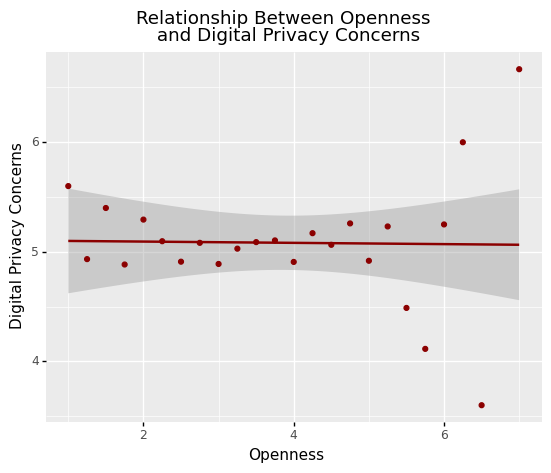

<ggplot: (8781887243207)>

In [102]:
mask = df.groupby(["openness"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
open_vs_pi = (
        ggplot(mask,
               aes(x="openness", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Openness") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Openness \n and Digital Privacy Concerns")
)
# save the plot
ggplot.save(self=open_vs_pi,
            filename="open_vs_pi.png",
            path="plots/")

# display the plot
open_vs_pi


#### 2.3.B) Extraversion on Digital Privacy Concerns

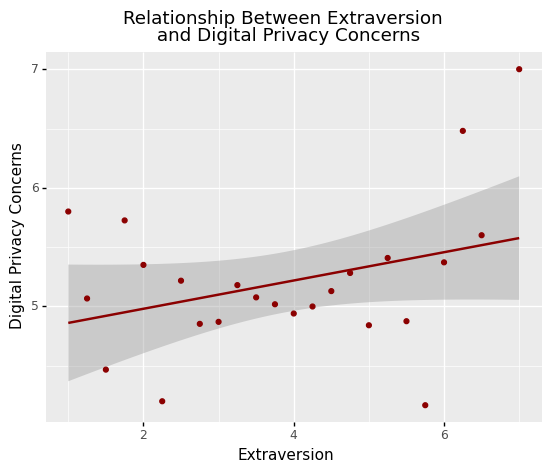

<ggplot: (8781889653857)>

In [103]:
mask = df.groupby(["extraversion"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
extr_vs_pi = (
        ggplot(mask,
               aes(x="extraversion", y="pi_concerns")) +
        geom_smooth(method="lm", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Extraversion") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Extraversion \n and Digital Privacy Concerns")
             )
# save the plot
ggplot.save(self=extr_vs_pi,
            filename="extr_vs_pi.png",
            path="plots/")

# display the plot
extr_vs_pi


#### 2.3.C) Neuroticism on Digital Privacy Concerns


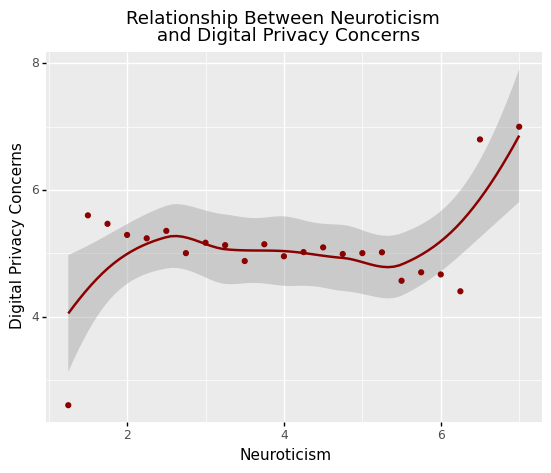

<ggplot: (8781888771100)>

In [104]:
mask = df.groupby(["neuroticism"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
neur_vs_pi = (
        ggplot(mask,
               aes(x="neuroticism", y="pi_concerns")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Neuroticism") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Neuroticism \n and Digital Privacy Concerns")
)
# save the plot
ggplot.save(self=neur_vs_pi,
            filename="neur_vs_pi.png",
            path="plots/")

# display the plot
neur_vs_pi

#### 2.3.D) Aggreableness on Digital Privacy Concerns

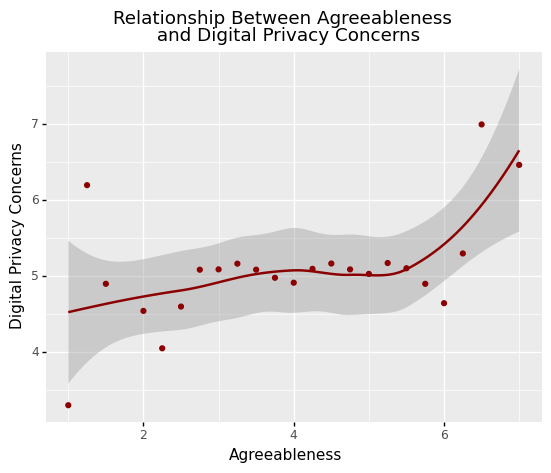

<ggplot: (8781889536790)>

In [105]:
mask = df.groupby(["agreeableness"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

# create the plot
agrb_vs_pi = (
        ggplot(mask,
               aes(x="agreeableness", y="pi_concerns")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Agreeableness") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Agreeableness \n and Digital Privacy Concerns")
             )
# save the plot
ggplot.save(self=agrb_vs_pi,
            filename="agrb_vs_pi.png",
            path="plots/")

# display the plot
agrb_vs_pi

#### 2.3.E) Conscientiousness on Digital Privacy Concerns

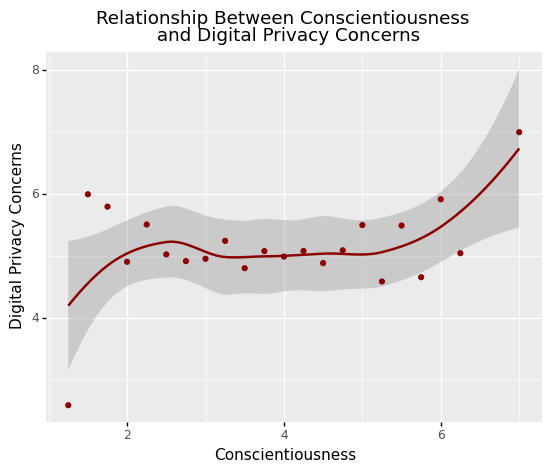

<ggplot: (8781890746534)>

In [106]:
mask = df.groupby(["conscientiousness"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)

#create the plot
cons_vs_pi = (
        ggplot(mask,
               aes(x="conscientiousness", y="pi_concerns")) +
        geom_smooth(method="loess", se=True, color="darkred") +
        geom_point(color="darkred") +
        xlab("Conscientiousness") +
        ylab("Digital Privacy Concerns") +
        ggtitle("Relationship Between Conscientiousness \n and Digital Privacy Concerns")
             )
# save the plot
ggplot.save(self=cons_vs_pi,
            filename="cons_vs_pi.png",
            path="plots/")

# display the plot
cons_vs_pi

Number of plotting dimensions can be increased. We can keep the X and Y axis and add further variables by using different colors to describe the third variable. We can divide the plot into sub-plots per each category of fourt variable. Perhaps even tweak the size of objects to indicate the fifth variable... I am not completely against the idea of multidimensional plotting. But there are two problems associated with this sort of exploration method.

First, due to extreme amount of possible combinations of the variables that can be used for plotting, going through all those combinations is neither viable nor cognitively helpful. I, personally can't keep track of all  multidimensional relationships this way. Second, even the one goes through all the plots and mental capacity to keep all the relationships in mind, being able to do the same can't be expected from the people who is going to listen to presentation or read your post. No matter who is your audience, business stakeholders or academic colleagues, things should be kept simple but informative.

The plot below is an example of where plotting starts to get counter-productive.

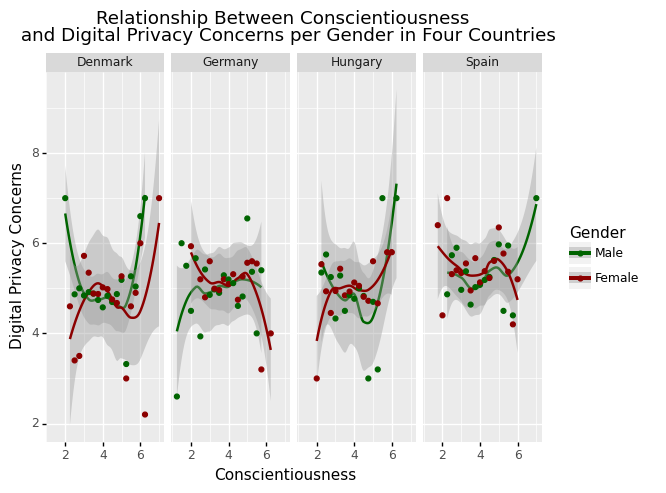

<ggplot: (8781888893600)>

In [107]:
mask = df.groupby(["conscientiousness", "gender", "country"])["pi_concerns"].mean().reset_index().copy()
mask.dropna(inplace=True)
# I am not goint to save this plot
(
        ggplot(mask,
               aes(x="conscientiousness",
                   y="pi_concerns",
                   color="factor(gender)")) +
        geom_smooth(method="loess", se=True) +
        geom_point() +
        facet_grid("~country") +
        xlab("Conscientiousness") +
        ylab("Digital Privacy Concerns") +
        scale_color_manual(name = "Gender",
                           values=["darkgreen", "darkred"],
                           labels=["Male", "Female"]) +
        ggtitle("Relationship Between Conscientiousness \n and Digital Privacy Concerns per Gender in Four Countries")
)


## 3) Modelling
In the Modelling I will use three approaches:
First, I will build a structural equation model. Second, I will apply classical multivariate regression, and in the last section I will use state-of-the art causal modelling package, DoWhy.



### 3.1) Structural Equation Modelling
SEM is super useful when you have a theory. You can build your effects graph, use measured and latent variables at the same time with super ease; test moderation, mediation, chains of mediation/moderation etc. It's super flexible.

In [108]:
df["female"] = pd.get_dummies(df["gender"],
                              drop_first=True).rename(columns={2.0:"Female"})

Above I just dummify the gender variable. I could have done it before too. But I specifically do it here to underline that categorical encoding is extremely important for SEM models. Female variable coded as 0-1 is not the same thing with gender variable coded as 1-2. You can try and see it for yourself. The same goes for any regression model too. However, with SEM it can be more tricky to see where the problem arises due to complex nature of the models inside it. So, put your categorical in shape always!

In [109]:
model_definition = """
    # MEASUREMENT MODEL

    ## Personality Taxonomy
    openness_l =~ open_a + open_b + open_c + open_d
    extraversion_l =~ extr_a + extr_b + extr_c + extr_d
    conscientiousness_l =~ cons_a + cons_b + cons_c + cons_d
    neuroticism_l =~ neur_a + neur_b + neur_c + neur_d
    agreeableness_l =~ agrb_a + agrb_b + agrb_c + agrb_d

    ## Institutional Trust
    trust_in_inst_l =~ trst_prl + trst_pol + trst_prt + trst_leg + trst_plc + trst_gov

    ## PI concerns
    pi_concerns_l =~ pi_misuse + pi_track + pi_safety + pi_share + pi_stranger

    # REGRESSION MODELS

    ## Income as function of
    income ~ female + age

    ## Personality as function of demographics
    openness_l  ~ age + income + female
    extraversion_l ~ age + income + female
    conscientiousness_l ~ age + income + female
    neuroticism_l ~ age + income + female
    agreeableness_l ~ age + income + female

    ## Trust in institutions as function of personality traits and demographics
    trust_in_inst_l ~ openness_l + extraversion_l + conscientiousness_l + neuroticism_l + agreeableness_l + female + age + income

    ### PI concerns  as function of Trust in institutions, personality traits and demographics
    pi_concerns_l ~ openness_l + extraversion_l + conscientiousness_l + neuroticism_l + agreeableness_l + trust_in_inst_l + female + age + income

"""


In the block above I first defined my latent variables at the measurement model. There I declared that left handside is defined by the ones at right handside.

In the second part, I started defining relationships:

Income is modelled as linear function of age and female.
The latent personality taxonomy dimensions that I previously defined are now being modelled as linear function of age gender and income.
Trust in institutions are modelled as linear function of personality traits, and demographics
And, digital privacy concerns are modelled as a function of personality traits, demographics and, trust in institutions.


In [110]:
# Instantiate the model
model = sm.Model(model_definition)

# Fit the model using the data
model.fit(df)

# Show the results using the inspect method
res = model.inspect()[:34]
res

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,income,~,female,-0.136061,0.048974,-2.778214,0.005466
1,income,~,age,-0.000271,0.001755,-0.154469,0.87724
2,openness_l,~,age,0.000535,0.001047,0.510987,0.60936
3,openness_l,~,income,0.018777,0.012719,1.476253,0.139876
4,openness_l,~,female,-0.000165,0.029261,-0.005645,0.995496
5,extraversion_l,~,age,0.004453,0.001581,2.815774,0.004866
6,extraversion_l,~,income,0.150362,0.019693,7.635124,0.0
7,extraversion_l,~,female,0.073971,0.044081,1.678089,0.09333
8,conscientiousness_l,~,age,0.007548,0.001111,6.79384,0.0
9,conscientiousness_l,~,income,0.056515,0.012851,4.3978,0.000011


The model is not simple. It contains serial mediations as well as a lot of latent variables. So it returns estimates for over 100 parameters. It's really tricky to interpret it. But the main problem here is that SEM takes all of the variables as treatment variable. It doesn't know anything about confoundedness. Before Judea Pearls' invention of causal DAGs almost all the researchers interpreted SEM results as causal estimates. The false idea of fitting one model to get answers to all questions is of course not SEM's fault. However, it's still common that most people fall into this trap. The comparison between SEM, regression and DoWhy results is going to show us the how wrong they can be.

Note: If below plot raises no graphviz module error, then you have to install python-graphviz from conda and restart the kernel

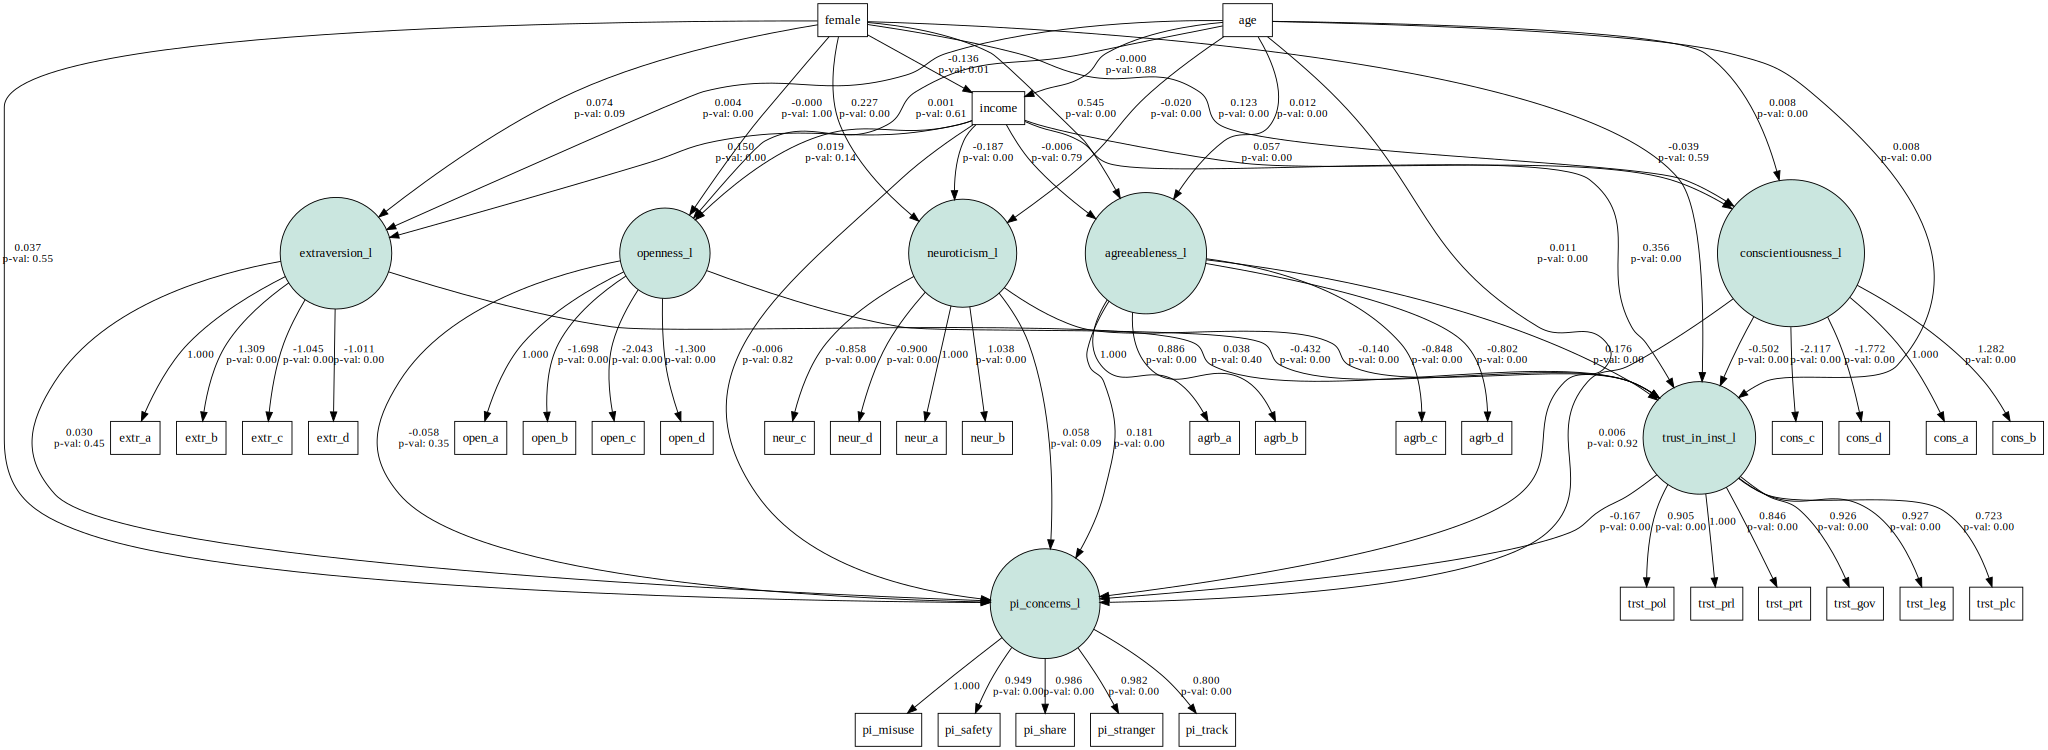

In [111]:
sm.semplot(model,
           "plots/sem_results.png",
           show=True,
           plot_exos=False,
           engine="dot")

In [112]:
sm.report(model, "sem_report")

 ## 3.2) Linear Regression
 No need to talk much about regression. I guess everyone knows what it does. It's simple but extremely powerful tool. However, just like SEM, if a researcher fits single model to get estimates for all the variables then regression models can return biased results. So check the summary and compare the key variables with SEM results.

In [115]:
mod = ols(formula="pi_concerns ~ trust_in_inst +agreeableness + openness + conscientiousness + extraversion + neuroticism + age+ female+ income", data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            pi_concerns   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     12.59
Date:                Fri, 31 Dec 2021   Prob (F-statistic):           1.08e-19
Time:                        22:04:22   Log-Likelihood:                -3720.1
No. Observations:                2219   AIC:                             7460.
Df Residuals:                    2209   BIC:                             7517.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.3083      0.29

# 3.3) Causal Modelling
DoWhy is a package created by researchers at Microsoft. It aims to bring a standalone package to cover four steps of causal modelling under single package.
1) Constructing the causal model using DAGs.
2) Identifying the correct estimand and  picking the necessary adjustment sets based on the causal model at step 1
3) Estimating the effect
4) Test for robustness of the effect using different refutation methods

Comparing to this four steps, What we lacked when using SEM were step 2 and 4. Ideally I should have defined different SEM models for each variable depending on their confoundedness. Then, after getting estimates from each model I should have applied the robustness tests manually. You can imagine how time and effort consuming task that is.

With the regression model, it was lacking step 1,2 and 4. There was no DAG, no identification, no robustness test. Again, this is not a problem of regression models. It's the fault of researcher. I could have done all the steps manually. However, building a model the way I did here is super common in academia and data science. My point in this notebook was to demonstrate the harms of it.

I did not demonstrate it here but there is also another particular trend among Data scientist that is equally harmful. They build predictive models using SVM, gradient boosting, forests etc and present SHAP plots as a causal story.

Anyway, let's use dowhy. First I will make my DAG

In [135]:
causal_graph = """digraph {
conscientiousness[label="conscientiousness"];
openness[label="openness"];
agreeableness[label="agreeableness"];
extraversion[label="extraversion"];
neuroticism[label="neuroticism"];
pi_concerns[label="privacy concerns"];
trust_in_inst[label="trust in institutions"];
female[label="female"];
income[label="income"];
age[label="age"];
age -> openness; age -> conscientiousness; age -> agreeableness; age -> extraversion; age -> neuroticism; age -> trust_in_inst; age-> pi_concerns; age -> income;
female -> openness; female -> conscientiousness; female -> agreeableness; female -> extraversion; female -> neuroticism; female -> trust_in_inst; female -> pi_concerns; female -> income;
income -> openness; income -> conscientiousness; income -> agreeableness; income -> extraversion; income -> neuroticism; income -> trust_in_inst; income -> pi_concerns;
conscientiousness -> trust_in_inst;
conscientiousness -> pi_concerns;
openness -> trust_in_inst;
openness -> pi_concerns;
agreeableness -> trust_in_inst;
agreeableness -> pi_concerns;
extraversion -> trust_in_inst;
extraversion -> pi_concerns;
neuroticism -> trust_in_inst;
neuroticism -> pi_concerns;
trust_in_inst -> pi_concerns;
}"""

Below I define my treatment and outcome variables. This is so important. DoWhy will only return the estimate for my treatment.

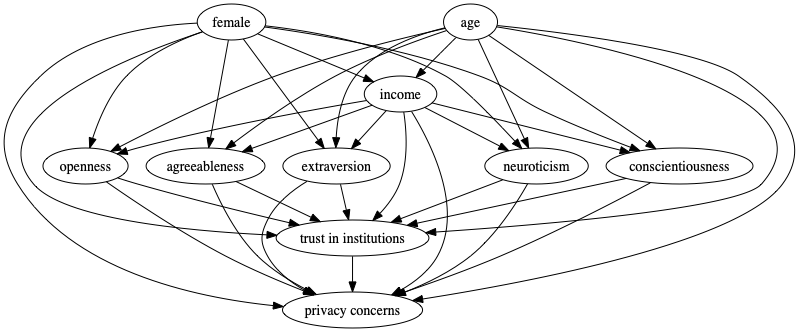

In [136]:
model= dowhy.CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='trust_in_inst',
        outcome='pi_concerns')
model.view_model()
display(Image(filename="causal_model.png"))

In [123]:
#Identify the causal effect
identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 test_significance=True
                                 )

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(Expectation(pi_concerns|neuroticism,extraversion,income,openne
d[trustᵢₙ ᵢₙₛₜ]                                                               

                                               
ss,agreeableness,conscientiousness,age,female))
                                               
Estimand assumption 1, Unconfoundedness: If U→{trust_in_inst} and U→pi_concerns then P(pi_concerns|trust_in_inst,neuroticism,extraversion,income,openness,agreeableness,conscientiousness,age,female,U) = P(pi_concerns|trust_in_inst,neuroticism,extraversion,income,openness,agreeableness,conscientiousness,age,female)

## Realized estimand
b: pi_concerns~trust_in_inst+neuroticism+extraversion+income+openness+agreeableness+conscientiousness+age+female
Target units: ate

## Es

If you scroll down, it reports the estimate and the p-value. It's the same estimate for all models. However, for the other variables regression and SEM did not agree.

DoWhy is reporting us the estimand assumption and the identification too.

So up till here we covered 3 of 4 steps of causal modelling, DAG, identification and estimation. Now comes the fourth, the refutation. First, I will add a random common cause. It's going to simulate a variable and add it as common cause between treatment and outcome. If our model was correct, the new estimate shoulnd't be too different than our original estimate.


In [124]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
                                      method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.16141111335687075
New effect:-0.1614361658653536



First one looks good. Almost the same estimate. Now comes the second refutation. DoWhy is able to assign a placebo. Basically it's going to simulate a random variable to substitute the treatment. If everything is fine, then the effect should approximate to 0. Below, it's the case.

In [125]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
                                      method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.16141111335687075
New effect:-2.398081733190338e-14
p value:0.0



And lastly, we can check the sensitivity. In the next step it's going to remove random subset of data and re-run the analysis. If all is good, then the effect should remain similar.

In [126]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
                                      method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:-0.16141111335687075
New effect:-0.15904256594770322
p value:0.44



Now I would like to proceed with getting the estimates for all other variables. I am not going to manually define different causal models for each variable. I think the graph that we used so far to estimate the impact of trust in institutions on pricavy concerns can be used for modelling the others as well. I know it's sort of a strong assumption but let's pretend this holds and see what happens.

Below I just loop over my variables and


In [127]:
variables = ["conscientiousness",
             "openness",
             "agreeableness",
             "extraversion",
             "neuroticism",
             "age",
             "female",
             "income",
             "trust_in_inst"]

list_of_estimates = []
list_of_p_values = []
list_of_models = []

for i in variables:
    # 1) define the model
    model= dowhy.CausalModel(data = df,
                             graph=causal_graph.replace("\n", " "),
                             treatment=i,
                             outcome='pi_concerns')
    # 2) identify estimands
    identified_estimand = model.identify_effect()
    # 3) estimate
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                     test_significance=True)
    # 4) Append the results
    list_of_estimates.append(estimate.value)
    list_of_models.append(estimate.realized_estimand_expr)
    for key, value in estimate.test_stat_significance().items():
        list_of_p_values.append(value)



In [134]:
causal_summary = pd.DataFrame({"variable": variables,
                               "estimate": list_of_estimates,
                               "p-value":list_of_p_values,
                               "model specification": list_of_models})

causal_summary

,variable,estimate,p-value,model specification
0,conscientiousness,0.01,[0.4694115598183991],b: pi_concerns~conscientiousness+neuroticism+e...
1,openness,0.01,[0.14083456846649117],b: pi_concerns~openness+neuroticism+extraversi...
2,agreeableness,0.05,[0.7777930082384379],b: pi_concerns~agreeableness+neuroticism+extra...
3,extraversion,0.09,[0.9688883829955918],b: pi_concerns~extraversion+neuroticism+income...
4,neuroticism,-0.08,[0.052325717013453225],b: pi_concerns~neuroticism+extraversion+income...
5,age,0.01,[4.267010440427129e-05],b: pi_concerns~age+female+age*female
6,female,0.16,[0.19699333995969998],b: pi_concerns~female+age+female*age
7,income,-0.07,[0.002895534046615438],b: pi_concerns~income+age+female
8,trust_in_inst,-0.16,[7.401282247451859e-15],b: pi_concerns~trust_in_inst+neuroticism+extra...


Well, you can see the difference in estimates. Also look how dowhy smartly picked different models depending on the confoundedness. I really admire their work. And I guees that was it from my side. I hope you enjoyed it. If you see any mistake please make sure to let me know. Thanks for reading it :)